In [1]:
import numpy as np
import pandas as pd
import pickle

import matplotlib.pyplot as plt
import powerlaw
from bokeh.io import output_file, save
from bokeh.models import ColumnDataSource
from bokeh.plotting import figure
from bokeh.palettes import d3

from IPython.display import FileLink

In [2]:
# Increase width to be able to better read the reviews when displaying dataframe
pd.options.display.max_colwidth = 100

In [3]:
# Constant definitions
REVIEW_FILE = "Grocery_and_Gourmet_Food.json"
REVIEW_PICKLE = "reviews"
META_FILE = "meta_Grocery_and_Gourmet_Food.json"
META_PICKLE = "meta"
DATA_LOCATION = "data/"
PICKLE_LOCATION = "processed-data/"
PLOTS_LOCATION = "milestone-2-plots/"

In [4]:
def load_pickle(pickle_name):
    with open(PICKLE_LOCATION+pickle_name, 'rb') as file:
        print(f'loading pickle for {pickle_name}...')
        return pickle.load(file)

In [5]:
def save_pickle(result, pickle_name):
    with open(PICKLE_LOCATION+pickle_name, 'wb') as file:
        print(f'saving pickle for {pickle_name}...')
        pickle.dump(result, file)

In [6]:
def read_file(file):
    if file == REVIEW_FILE:
        pickle_name = REVIEW_PICKLE
    elif file == META_FILE:
        pickle_name = META_PICKLE
    else:
        pickle_name = file
    
    try:
        return load_pickle(pickle_name)
    except (FileNotFoundError, EOFError) as e:
        file_df = pd.read_json(DATA_LOCATION+file, lines=True)
        save_pickle(file_df, pickle_name)
        return file_df

First we load the data and see what it looks like, in order to sanitize it.

We have 2 data files, one containing Amazon 'Grocery and Gourmet Food' reviews, the other one containing meta information about the products.

In [7]:
reviews = read_file(REVIEW_FILE)
meta = read_file(META_FILE)
print("Meta dataset:")
display(meta.head())
print("\nReviews dataset:")
reviews

loading pickle for reviews...
loading pickle for meta...
Meta dataset:


,category,description,title,brand,rank,also_view,main_cat,price,asin,also_buy,image,date,feature,details,similar_item,tech1,fit
0,"[Grocery & Gourmet Food, Dairy, Cheese & Eggs, Cheese, Gouda]","[BEEMSTER GOUDA CHEESE AGED 18/24 MONTHS, Statements regarding dietary supplements have not been...",Beemster Gouda - Aged 18/24 Months - App. 1.5 Lbs,Ariola Imports,"165,181inGroceryGourmetFood(","[B0000D9MYM, B0000D9MYL, B00ADHIGBA, B00H9OX598, B001LM42GY, B001LM5TDY]",Grocery,$41.91,0681727810,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"[Grocery & Gourmet Food, Cooking & Baking, Sugar Substitutes, Xylitol]","[Shipped from UK, please allow 10 to 21 business days for arrival. ex lib pub by Applied Science...",Trim Healthy Mama Xylitol,NaN,"315,867inGroceryGourmetFood(",NaN,Grocery,NaN,0853347867,"[B01898YHXK, B01BCM6LAC, B00Q4OL47O, B00Q4OL5QE, 0804189986, B00Q4OL2F8, 1101902663, B019PDEUU8,...","[https://images-na.ssl-images-amazon.com/images/I/5135fT93xtL._SS40_.jpg, https://images-na.ssl-...",NaN,NaN,NaN,NaN,NaN,NaN
2,"[Grocery & Gourmet Food, Cooking & Baking, Frosting, Icing & Decorations, Cake & Cupcake Toppers...",[Jazz up your cakes with a sparkling monogram from our Sparkling collection! These single letter...,Letter C - Swarovski Crystal Monogram Wedding Cake Topper Letter,Unik Occasions,">#669,941 in Kitchen & Dining (See Top 100 in Kitchen & Dining)>#9,899 in Kitchen & Dining > Bak...",[B07DXN65TF],Amazon Home,$29.95,1888861118,NaN,NaN,"September 21, 2010",NaN,NaN,NaN,NaN,NaN
3,"[Grocery & Gourmet Food, Cooking & Baking, Frosting, Icing & Decorations, Cake & Cupcake Toppers...","[Large Letter - Height 4.75""]",Letter H - Swarovski Crystal Monogram Wedding Cake Topper Letter,Other,">#832,581 in Kitchen & Dining (See Top 100 in Kitchen & Dining)>#12,883 in Kitchen & Dining > Ba...",NaN,Amazon Home,$11.45,1888861517,NaN,NaN,"September 11, 2011","[Large Letter - Height 4.75""]",NaN,NaN,NaN,NaN
4,"[Grocery & Gourmet Food, Cooking & Baking, Frosting, Icing & Decorations, Cake & Cupcake Toppers...","[4.75""]",Letter S - Swarovski Crystal Monogram Wedding Cake Topper Letter,Unik Occasions,">#590,999 in Kitchen & Dining (See Top 100 in Kitchen & Dining)>#8,585 in Kitchen & Dining > Bak...",NaN,Amazon Home,$15.00,1888861614,NaN,NaN,"September 11, 2011","[4.75"" height]",NaN,NaN,NaN,NaN



Reviews dataset:


,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,image,style
0,5,True,"06 4, 2013",ALP49FBWT4I7V,1888861614,Lori,Very pleased with my purchase. Looks exactly like the picture and will look great on my cake. It...,Love it,1370304000,NaN,NaN,NaN
1,4,True,"05 23, 2014",A1KPIZOCLB9FZ8,1888861614,BK Shopper,Very nicely crafted but too small. Am going to have to add some flowers or something to compensa...,Nice but small,1400803200,NaN,NaN,NaN
2,4,True,"05 9, 2014",A2W0FA06IYAYQE,1888861614,daninethequeen,still very pretty and well made...i am super picky so don't listen to me...*whispers* but it doe...,"the ""s"" looks like a 5, kina",1399593600,NaN,NaN,NaN
3,5,True,"04 20, 2014",A2PTZTCH2QUYBC,1888861614,Tammara,"I got this for our wedding cake, and it was everything even more on in person, I would recommend...",Would recommend this to a friend!,1397952000,NaN,NaN,NaN
4,4,True,"04 16, 2014",A2VNHGJ59N4Z90,1888861614,LaQuinta Alexander,It was just what I want to put at the top of my wedding cake. I love it & it's true to the picture.,Topper,1397606400,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
5074155,5,True,"10 4, 2018",AGOPF2VTEOP57,B01HJHSVG6,Bob,"Love this product, very fresh, complete full flavor, will buy again",Exceclent product,1538611200,NaN,NaN,{'Size:': ' 2.29 oz'}
5074156,3,True,"10 3, 2018",A5X5TI4JCH9CN,B01HJHSVG6,Jacqueline Schafer,Good taste but small quantity for the expensive price. Organic vanilla is usually not so expensi...,Good taste but small quantity for the price used 3/4 of this for 1 recipe,1538524800,NaN,NaN,{'Size:': ' 2.29 oz'}
5074157,4,True,"10 2, 2018",A1WMQQLC3TVAFI,B01HJHSVG6,Motionjunkie,"Unlike some of the bad reviews regarding aroma, when I opened the glass jar, I got a good whiff ...",See Comments below,1538438400,NaN,NaN,{'Size:': ' 2.29 oz'}
5074158,5,True,"09 30, 2018",ALVP6JZRTEDY6,B01HJHSVG6,Marissa,I absolutely love this vanilla bean paste. I had been using vanilla extract for my dessert and b...,Love!!,1538265600,NaN,NaN,{'Size:': ' 2.29 oz'}


We have 5'064'160 reviews and these reviews have 12 attributes. Here is [an example](https://www.amazon.com/gp/customer-reviews/R3OL49W8SWC4EW/ref=cm_cr_arp_d_rvw_ttl?ie=UTF8&ASIN=B0000D916Y) of an Amazon review to illustrate, coming from [this product](https://www.amazon.com/Davids-Cookies-Christmas-Corporate-Certified/dp/B0000D916Y/ref=cm_cr_arp_d_product_top?ie=UTF8).

<img src="misc/amazon-review-example.png">

First let's try to find this review.

In [8]:
reviews_example = reviews[reviews["summary"] == "Not your average tin of cookies!"]
reviews_example

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,image,style
7935,5,False,"01 22, 2018",A129TBMOQD79CZ,B0000D916Y,Shawna J. Pierce,Someone sent us a tin of Davids Cookies over the holidays and they were DELICIOUS. These are now...,Not your average tin of cookies!,1516579200,NaN,NaN,"{'Size:': ' 1 lbs (12 -1.5oz cookies)', 'Flavor:': ' Chocolate Chunk'}"
9256,5,False,"01 22, 2018",A129TBMOQD79CZ,B0000D9169,Shawna J. Pierce,Someone sent us a tin of Davids Cookies over the holidays and they were DELICIOUS. These are now...,Not your average tin of cookies!,1516579200,NaN,NaN,NaN


Weird, these two reviews look like they are almost the same, but we'll get back to it later. Let's first understand the columns. Using this review: (and image to help comparing)

<img src="misc/amazon-review-example.png">

In [9]:
reviews_example[reviews_example["style"].notnull()]

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,image,style
7935,5,False,"01 22, 2018",A129TBMOQD79CZ,B0000D916Y,Shawna J. Pierce,Someone sent us a tin of Davids Cookies over the holidays and they were DELICIOUS. These are now...,Not your average tin of cookies!,1516579200,NaN,NaN,"{'Size:': ' 1 lbs (12 -1.5oz cookies)', 'Flavor:': ' Chocolate Chunk'}"


`overall`: the number of stars\
`verified`: tells us if the purchase has been verified, not the case here\
`reviewTime`: Time of the review (day)\
`reviewerID`: Id of the reviewer\
`asin`: Id of the reviewed product (here the cookies)\
`reviewerName`: The name of the reviewer\
`reviewText`: The content of the review\
`summary`: The small sentence to summarize the review (the bold text on the image)\
`unixReviewTime`: Time of the review in unix time\
`vote`: The number of "Helpful" a review has received, here it has received 0. So the value is NaN, they are in essence upvotes.\
`image`: You can link an image in your review on Amazon, here there is none\
`style`: The greyish link below the date, right below the date. It is in fact a link to buy this product: 12 cookies and chocolate chunk flavor

Here you can see an example of a verified review, with 6 upvotes:

<img src="misc/amazon-review-example-upvote.png">

Now let's look at bit closer at why we have two different reviews that look like they are the same.

In [10]:
# Show values that differ in the two reviews
reviews_example.loc[:, reviews_example.values[0] != reviews_example.values[1]]

,asin,vote,image,style
7935,B0000D916Y,NaN,NaN,"{'Size:': ' 1 lbs (12 -1.5oz cookies)', 'Flavor:': ' Chocolate Chunk'}"
9256,B0000D9169,NaN,NaN,NaN


So one of them has `style` while the other one doesn't and they are apparently not about the same product. This sounds weird, why would a person post the exact same comment for two different products?

Let's take a closer look at these two products

In [11]:
asins_example = reviews_example['asin'].values
product1 = meta[meta["asin"] == asins_example[0]]
product1

,category,description,title,brand,rank,also_view,main_cat,price,asin,also_buy,image,date,feature,details,similar_item,tech1,fit
402,"[Grocery & Gourmet Food, Snack Foods, Cookies, Chocolate Chip]","[, For those in search of a delicious, fresh, and certified kosher gift for family, friends, or ...","David's Cookies - 24 Fresh Baked M&M Candy Cookie Gourmet Gift Basket - Christmas, Holiday & Cor...",David's Cookies,"299,472inGroceryGourmetFood(","[B0000DA0XJ, B000PQQQSO, B000BB4SUG, B01NCEV877, B07KWG1PG2, B01E4KN8DM, B01N8OP47H, B00F4DF9JU,...",Grocery,NaN,B0000D916Y,"[B000BB4SUG, B01NCEV877, B000PQQQSO, B01E4KN8DM, B0000DA0XJ, B07KWG1PG2, B000PQQR4W, B01N8OP47H,...","[https://images-na.ssl-images-amazon.com/images/I/51X3C40yx%2BL._SS40_.jpg, https://images-na.ss...",NaN,NaN,"\n\n\n\n\n\n <div class=""disclaim"">Flavor: <strong>M&M</strong>&nbsp;|&nbsp;Size: <strong>2 l...",NaN,NaN,NaN
4099,"[Grocery & Gourmet Food, Snack Foods, Cookies, Chocolate Chip]","[, For those in search of a delicious, fresh, and certified kosher gift for family, friends, or ...","David's Cookies - 24 Fresh Baked M&M Candy Cookie Gourmet Gift Basket - Christmas, Holiday & Cor...",David's Cookies,"299,472inGroceryGourmetFood(","[B0000DA0XJ, B000PQQQSO, B000BB4SUG, B01NCEV877, B07KWG1PG2, B01E4KN8DM, B01N8OP47H, B00F4DF9JU,...",Grocery,NaN,B0000D916Y,"[B000BB4SUG, B01NCEV877, B000PQQQSO, B01E4KN8DM, B0000DA0XJ, B07KWG1PG2, B000PQQR4W, B01N8OP47H,...","[https://images-na.ssl-images-amazon.com/images/I/51X3C40yx%2BL._SS40_.jpg, https://images-na.ss...",NaN,NaN,"\n\n\n\n\n\n <div class=""disclaim"">Flavor: <strong>M&M</strong>&nbsp;|&nbsp;Size: <strong>2 l...",NaN,NaN,NaN


Two rows again, how weird! Let's look at how they differ:

In [12]:
product1.loc[:, product1.values[0] != product1.values[1]]

,price,date,feature,similar_item,tech1,fit
402,NaN,NaN,NaN,NaN,NaN,NaN
4099,NaN,NaN,NaN,NaN,NaN,NaN


This time they are exactly the same, that's interesting to note. We could safely remove one of them.

Let's look at the second product:

In [13]:
product2 = meta[meta["asin"] == asins_example[1]]
product2

,category,description,title,brand,rank,also_view,main_cat,price,asin,also_buy,image,date,feature,details,similar_item,tech1,fit
435,"[Grocery & Gourmet Food, Snack Foods, Cookies, Chocolate Chip]",NaN,"David's Cookies - 24 Fresh Baked Assorted Cookies Gourmet Gift Basket - Christmas, Holiday & Cor...",David's Cookies,"29,374inGroceryGourmetFood(","[B0000DA0XJ, B000PQQQSO, B000BB4SUG, B01NCEV877, B07KWG1PG2, B01E4KN8DM, B01N8OP47H, B00F4DF9JU,...",Grocery,$38.95,B0000D9169,"[B000BB4SUG, B01NCEV877, B000PQQQSO, B01E4KN8DM, B0000DA0XJ, B07KWG1PG2, B07KWFX2M3, B01N8OP47H,...","[https://images-na.ssl-images-amazon.com/images/I/51Qy2CQ-R1L._SS40_.jpg, https://images-na.ssl-...",NaN,NaN,"\n\n\n\n\n\n <div class=""disclaim"">Flavor: <strong>Assorted Flavors</strong>&nbsp;|&nbsp;Size...",NaN,NaN,NaN
4132,"[Grocery & Gourmet Food, Snack Foods, Cookies, Chocolate Chip]",NaN,"David's Cookies - 24 Fresh Baked Assorted Cookies Gourmet Gift Basket - Christmas, Holiday & Cor...",David's Cookies,"29,374inGroceryGourmetFood(","[B0000DA0XJ, B000PQQQSO, B000BB4SUG, B01NCEV877, B07KWG1PG2, B01E4KN8DM, B01N8OP47H, B00F4DF9JU,...",Grocery,$38.95,B0000D9169,"[B000BB4SUG, B01NCEV877, B000PQQQSO, B01E4KN8DM, B0000DA0XJ, B07KWG1PG2, B07KWFX2M3, B01N8OP47H,...","[https://images-na.ssl-images-amazon.com/images/I/51Qy2CQ-R1L._SS40_.jpg, https://images-na.ssl-...",NaN,NaN,"\n\n\n\n\n\n <div class=""disclaim"">Flavor: <strong>Assorted Flavors</strong>&nbsp;|&nbsp;Size...",NaN,NaN,NaN


In [14]:
product2.loc[:, product2.values[0] != product2.values[1]]

,description,date,feature,similar_item,tech1,fit
435,NaN,NaN,NaN,NaN,NaN,NaN
4132,NaN,NaN,NaN,NaN,NaN,NaN


Again!

But how are these two products different?

In [15]:
two_products = pd.DataFrame([product1.values[0], product2.values[0]], columns=product1.columns)
two_products.loc[:, two_products.values[0] != two_products.values[1]]

,description,title,rank,price,asin,also_buy,image,date,feature,details,similar_item,tech1,fit
0,"[, For those in search of a delicious, fresh, and certified kosher gift for family, friends, or ...","David's Cookies - 24 Fresh Baked M&M Candy Cookie Gourmet Gift Basket - Christmas, Holiday & Cor...","299,472inGroceryGourmetFood(",NaN,B0000D916Y,"[B000BB4SUG, B01NCEV877, B000PQQQSO, B01E4KN8DM, B0000DA0XJ, B07KWG1PG2, B000PQQR4W, B01N8OP47H,...","[https://images-na.ssl-images-amazon.com/images/I/51X3C40yx%2BL._SS40_.jpg, https://images-na.ss...",NaN,NaN,"\n\n\n\n\n\n <div class=""disclaim"">Flavor: <strong>M&M</strong>&nbsp;|&nbsp;Size: <strong>2 l...",NaN,NaN,NaN
1,NaN,"David's Cookies - 24 Fresh Baked Assorted Cookies Gourmet Gift Basket - Christmas, Holiday & Cor...","29,374inGroceryGourmetFood(",$38.95,B0000D9169,"[B000BB4SUG, B01NCEV877, B000PQQQSO, B01E4KN8DM, B0000DA0XJ, B07KWG1PG2, B07KWFX2M3, B01N8OP47H,...","[https://images-na.ssl-images-amazon.com/images/I/51Qy2CQ-R1L._SS40_.jpg, https://images-na.ssl-...",NaN,NaN,"\n\n\n\n\n\n <div class=""disclaim"">Flavor: <strong>Assorted Flavors</strong>&nbsp;|&nbsp;Size...",NaN,NaN,NaN


Let's look at the title more closely:

In [16]:
print(two_products.values[0][2])
print(two_products.values[1][2])

David's Cookies - 24 Fresh Baked M&M Candy Cookie Gourmet Gift Basket - Christmas, Holiday & Corporate Food Tin - Idea For Men & Women - Certified Kosher - 2 lb.
David's Cookies - 24 Fresh Baked Assorted Cookies Gourmet Gift Basket - Christmas, Holiday & Corporate Food Tin - Idea For Men & Women - Certified Kosher - 2lb


In fact we think this is due to Amazon products having different 'categories', so that one of them represents the product and the other one would represent the version of the product that the customer bought. Thus why the review is duplicated: the reviewer bought and reviewed one version of those cookies, and thus has also reviewed the 'global' product. This would also explain why the rank of the global one is much higher than the other one, and why one of them doesn't have a price: each version of the product is the same price, they just come in different flavors. As you can see on this picture of the product, this product has multiple versions and the first one is 'Assorted':

<img src="misc/example-product.png">

So to summarize, we should remove products that are exact duplicates but not the ones that look similar but still have some minor differences. We also think we shouldn't remove reviews that look alike as it's complicated and they don't review "the same product" (their 'asin', i.e. the id of it, will differ) so they don't bias the trends.

Speaking of things to remove: there are columns in our dataset which aren't too interesting for our analysis, let's see what they are. First, we'll see what percentage of each columns are missing. in the meta data of our products, we drop the attribute that we don't use.

In [17]:
print("Meta dataset:")
display(pd.DataFrame(100 * meta.isnull().sum() / len(meta.index)).T)

print("\nReviews dataset:")
pd.DataFrame(100 * reviews.isnull().sum() / len(reviews.index)).T

Meta dataset:


,category,description,title,brand,rank,also_view,main_cat,price,asin,also_buy,image,date,feature,details,similar_item,tech1,fit
0,0.0,12.327956,0.001393,3.976895,4.078911,57.866223,0.519831,53.993085,0.0,70.985589,47.698714,96.635551,94.298925,4.834807,99.910866,99.740955,99.998607



Reviews dataset:


,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,image,style
0,0.0,0.0,0.0,0.0,0.0,0.006996,0.056817,0.026152,0.0,87.003327,98.602035,55.158608


As you can see multiple of these columns have a lot of missing values and some of them are not too interesting for us.

For meta: we decided to remove also_view, also_buy, image, feature, details, similar_item, tech1, fit because they have missing values and they won't be very useful for us. We are interested in reviews and in text. We want to analyze user behavior and want to be able to know what product they are talking about. But we don't really want to analyze the product themselves, so knowing what items are similar and whatnot isn't useful here.

For reviews: we will keep most of the features but we will remove unixReviewTime, image and style. We keep vote because NaN values are 0, so we can clean it. unixReviewTime isn't very useful since we have the date of the day (none are missing) which is precise enough. We will not use image nor style in our analysis as they don't bring information for what we want to do.

In [18]:
def format_reviews(reviews):
    # Drop columns we won't use
    reviews_dropped = ['unixReviewTime', 'image', 'style']
    reviews.drop(columns=reviews_dropped, inplace=True)
    
    # Rename columns to have more understandable names
    reviews.rename(columns={'overall': 'stars', 'vote': 'upvote'}, inplace=True)
    
    reviews["stars"] = reviews["stars"].astype(int)
    reviews["verified"] = reviews["verified"].astype(bool)
    
    # Cast reviewTime to date
    reviews["reviewTime"] = reviews["reviewTime"].str.replace("^0", "")
    reviews["reviewTime"] = pd.to_datetime(reviews["reviewTime"], format="%m %d, %Y")
    
    # Cast vote to int, while changing NaN values to 0
    #reviews.loc[reviews["vote"].isnull(), "vote"] = "0"
    reviews["upvote"] = reviews["upvote"].str.replace(",", "") # Thousands are separated with commas, we remove them. e.g. 1,881 = 1881
    reviews["upvote"].fillna(0, inplace=True)
    reviews["upvote"] = reviews["upvote"].astype(int)
    
    # transform nan values in reviewText and summary to empty string
    reviews["reviewText"].fillna("", inplace=True)
    reviews["summary"].fillna("", inplace=True)

def format_meta(meta):
    # Drop columns we won't use
    meta_dropped = ['also_view', 'also_buy', 'image', 'feature', 'details', 'similar_item', 'tech1', 'fit']
    meta.drop(columns=meta_dropped, inplace=True)

    cols_string = ['title', 'main_cat', 'brand', 'rank']
    meta.loc[:, cols_string] = meta.loc[:, cols_string].fillna("")
    meta.loc[:, cols_string] = meta.loc[:, cols_string].astype(str)

    # Map the list representation of category, description to string
    # We do that as working with strings is easier and more efficient with panda
    cols_list_to_string = ['category', 'description']
    meta.loc[:, cols_list_to_string] = meta.loc[:, cols_list_to_string].fillna("")
    meta.loc[:, cols_list_to_string] = meta.loc[:, cols_list_to_string].applymap(lambda l: '||'.join(l))
    meta.loc[:, cols_list_to_string] = meta.loc[:, cols_list_to_string].astype(str)
    
    # Dropping the duplicates, as explained before
    meta.drop_duplicates(inplace=True)

    # All prices start with $ or are NaN
    meta['price'] = pd.to_numeric(meta['price'].str.replace('$', '', regex=False), errors='coerce')

    # Cast date column to date format
    meta['date'] = pd.to_datetime(meta['date'], errors='coerce')

In [19]:
format_reviews(reviews)
format_meta(meta)

Let's see how the formatting affects our dataframes

In [20]:
display(reviews.head())
display(meta.head())

,stars,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,upvote
0,5,True,2013-06-04,ALP49FBWT4I7V,1888861614,Lori,Very pleased with my purchase. Looks exactly like the picture and will look great on my cake. It...,Love it,0
1,4,True,2014-05-23,A1KPIZOCLB9FZ8,1888861614,BK Shopper,Very nicely crafted but too small. Am going to have to add some flowers or something to compensa...,Nice but small,0
2,4,True,2014-05-09,A2W0FA06IYAYQE,1888861614,daninethequeen,still very pretty and well made...i am super picky so don't listen to me...*whispers* but it doe...,"the ""s"" looks like a 5, kina",0
3,5,True,2014-04-20,A2PTZTCH2QUYBC,1888861614,Tammara,"I got this for our wedding cake, and it was everything even more on in person, I would recommend...",Would recommend this to a friend!,0
4,4,True,2014-04-16,A2VNHGJ59N4Z90,1888861614,LaQuinta Alexander,It was just what I want to put at the top of my wedding cake. I love it & it's true to the picture.,Topper,0


,category,description,title,brand,rank,main_cat,price,asin,date
0,"Grocery & Gourmet Food||Dairy, Cheese & Eggs||Cheese||Gouda",BEEMSTER GOUDA CHEESE AGED 18/24 MONTHS||Statements regarding dietary supplements have not been ...,Beemster Gouda - Aged 18/24 Months - App. 1.5 Lbs,Ariola Imports,"165,181inGroceryGourmetFood(",Grocery,41.91,0681727810,NaT
1,Grocery & Gourmet Food||Cooking & Baking||Sugar Substitutes||Xylitol,"Shipped from UK, please allow 10 to 21 business days for arrival. ex lib pub by Applied Science ...",Trim Healthy Mama Xylitol,,"315,867inGroceryGourmetFood(",Grocery,NaN,0853347867,NaT
2,"Grocery & Gourmet Food||Cooking & Baking||Frosting, Icing & Decorations||Cake & Cupcake Toppers|...",Jazz up your cakes with a sparkling monogram from our Sparkling collection! These single letter ...,Letter C - Swarovski Crystal Monogram Wedding Cake Topper Letter,Unik Occasions,">#669,941 in Kitchen & Dining (See Top 100 in Kitchen & Dining)>#9,899 in Kitchen & Dining > Bak...",Amazon Home,29.95,1888861118,2010-09-21
3,"Grocery & Gourmet Food||Cooking & Baking||Frosting, Icing & Decorations||Cake & Cupcake Toppers|...","Large Letter - Height 4.75""",Letter H - Swarovski Crystal Monogram Wedding Cake Topper Letter,Other,">#832,581 in Kitchen & Dining (See Top 100 in Kitchen & Dining)>#12,883 in Kitchen & Dining > Ba...",Amazon Home,11.45,1888861517,2011-09-11
4,"Grocery & Gourmet Food||Cooking & Baking||Frosting, Icing & Decorations||Cake & Cupcake Toppers|...","4.75""",Letter S - Swarovski Crystal Monogram Wedding Cake Topper Letter,Unik Occasions,">#590,999 in Kitchen & Dining (See Top 100 in Kitchen & Dining)>#8,585 in Kitchen & Dining > Bak...",Amazon Home,15.00,1888861614,2011-09-11


Nice! We can now proceed with the analysis!

## Feature distribution analysis

Now let's see what the reviews look like on a broad view. As they'll be our main source of data for analysis we need to have a good idea of how they are.

The features that are the most interesting are `stars`, `verified`, `reviewTime`, `reviewText` and `upvote`. A recap of what they mean:
- `stars`: How a product was appreciated
- `verified`: If the purchase has been verified, 
- `reviewTime`: The day the review has been posted
- `reviewText`: The content of the review
- `upvote`: The number of upvotes/helpful on a review

Of course all the feature we have are of some interest, but these ones are the most interesting, so we'll take a look at them in more detail.

First, let's see some information about `stars` and `upvote`

In [21]:
reviews.describe()

,stars,upvote
count,5.074160e+06,5.074160e+06
mean,4.314708e+00,8.295479e-01
std,1.249303e+00,1.206719e+01
min,1.000000e+00,0.000000e+00
25%,4.000000e+00,0.000000e+00
50%,5.000000e+00,0.000000e+00
75%,5.000000e+00,0.000000e+00
max,5.000000e+00,1.217400e+04


As you can see a vast majority of reviews don't have any upvotes, and most of the reviews give a high amount of stars, 25% percentile is already at 4 stars! The number of upvotes probably follows a power law, let's plot them to verify!

In [27]:
def plot_bar_distribution(data, title, xlabel, ylabel, yscale='linear', width=0.8, figsize=(12, 8), categorical=False):
    counts = np.bincount(data)
    values = np.nonzero(counts)[0]
    counts = counts[values]
    
    plt.figure(figsize=figsize)
    plt.bar(values, counts, width=width)
    if categorical:
        plt.xticks(values)
    plt.title(title, fontsize=15)
    plt.xlabel(xlabel, fontsize=13)
    plt.ylabel(ylabel, fontsize=13)
    plt.yscale(yscale)
    plt.show()

In [16]:
def plot_ccdf_power_law(data, title, xlabel, ylabel, xmin=0, discrete=True, figsize=(10,8)):
    fit = powerlaw.Fit(data, xmin=xmin, discrete=discrete)
    plt.figure(figsize=figsize)
    ax = plt.gca()
    fit.power_law.plot_ccdf(color='b', linestyle='--', label='fit ccdf', ax=ax)
    fit.plot_ccdf(color='b', label='actual ccdf', ax=ax)
    plt.title(title, fontsize=15)
    plt.xlabel(xlabel, fontsize=13)
    plt.ylabel(ylabel, fontsize=13)
    plt.legend()
    plt.show() 

We will plot the number of stars

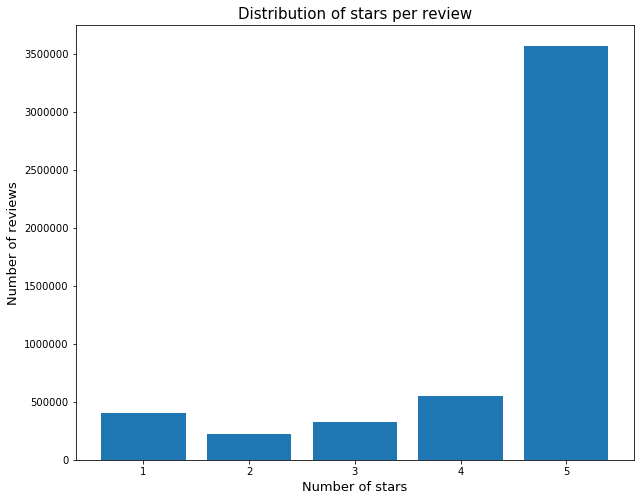

In [29]:
plot_bar_distribution(reviews['stars'],\
                      title="Distribution of stars per review",\
                      xlabel="Number of stars",\
                      ylabel="Number of reviews",\
                      figsize=(10,8),\
                      categorical=True)

As you can see a vast majority of reviews give 5 stars, but there are more 1 star than 2 or 3 stars, which is intersting. We can see that people usually review in the extreme either they think it's good so they give 4 or 5, or they thought it's trash and give 1.

Let's now take a look at `verified`.

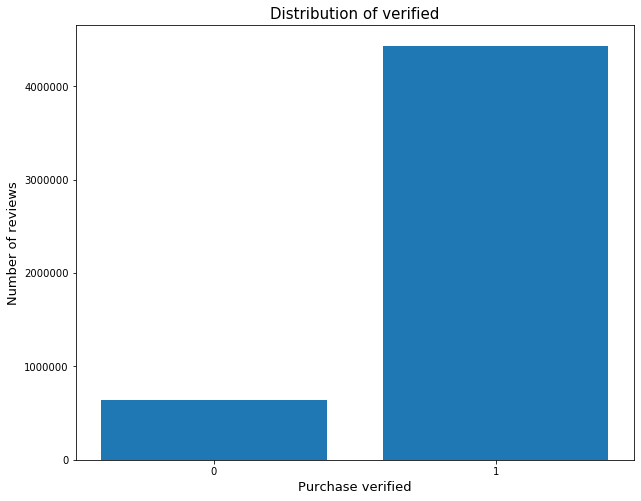

In [41]:
plot_bar_distribution(reviews['verified'],\
                      title="Distribution of verified",\
                      xlabel="Purchase verified",\
                      ylabel="Number of reviews",\
                      figsize=(10,8),\
                      categorical=True)

This is interesting and good news! As we can see most of the reviews are verified, so most of the reviews come from people that actually bought the product.

Let's plot the distribution of upvotes and compare it with the power law.

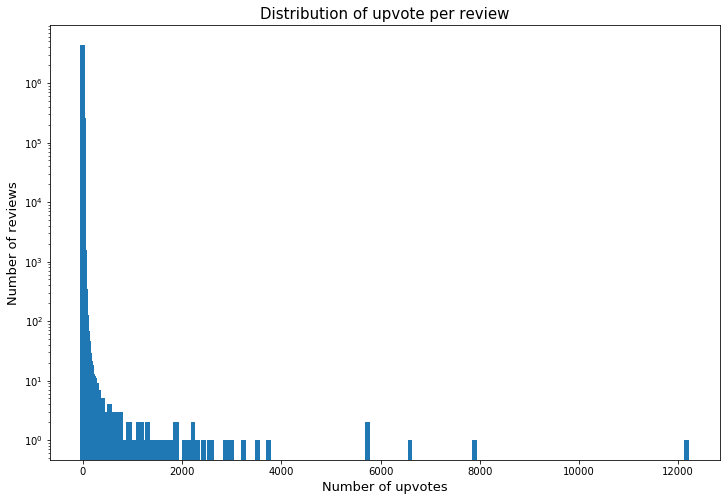

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/home/lulu/.venv/lib/python3.8/site-packages/powerlaw.py:699: RuntimeWarning: invalid value encountered in true_divide
  (CDF_diff**2) /
/home/lulu/.venv/lib/python3.8/site-packages/powerlaw.py:699: RuntimeWarning: divide by zero encountered in true_divide
  (CDF_diff**2) /


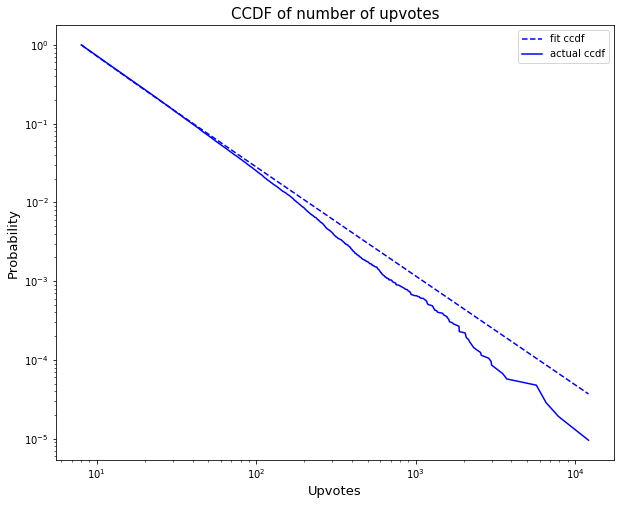

In [30]:
plot_bar_distribution(reviews['upvote'],\
                      title="Distribution of upvote per review",\
                      xlabel="Number of upvotes",\
                      ylabel="Number of reviews",\
                      yscale="log",\
                      width=100)

plot_ccdf_power_law(reviews['upvote'],\
                    title="CCDF of number of upvotes",\
                    xlabel="Upvotes",\
                    ylabel="Probability")

We can see that it indeed follows a power law, most of the reviews have 0 upvotes, but there are some with a high amount of upvotes.

Something to note that'll be able to see later on is that reviews with a huge amount of upvotes probably are jokes or memes. Otherwise it doesn't really make sense for a review to have so many upvotes.

Let's take a look at `reviewText` we can try to plot the distribution of the length of the reviews. It should also follow a power law.

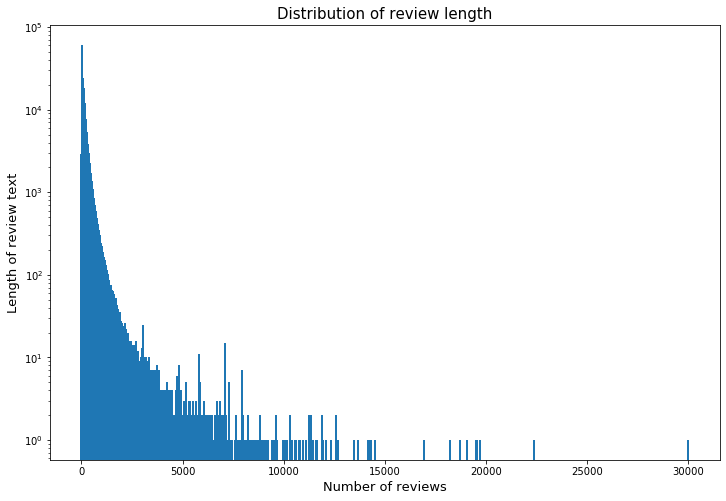

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit


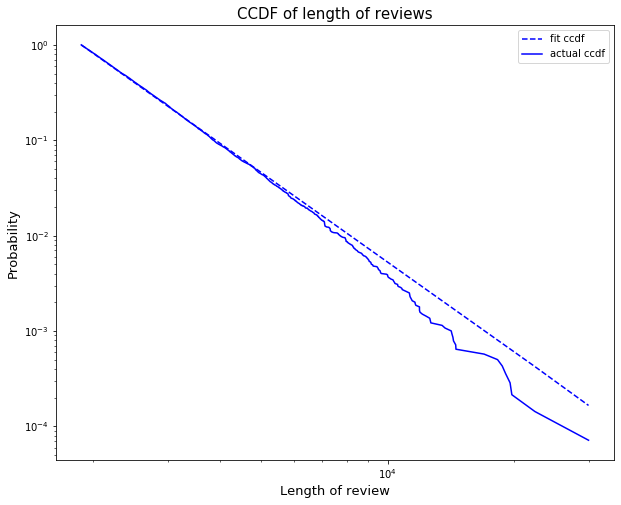

In [31]:
plot_bar_distribution(reviews['reviewText'].str.len(),\
                      title="Distribution of review length",\
                      xlabel="Number of reviews",\
                      ylabel="Length of review text",\
                      yscale="log",\
                      width=100)

plot_ccdf_power_law(reviews['reviewText'].str.len(),\
                    title="CCDF of length of reviews",\
                    xlabel="Length of review",\
                    ylabel="Probability")

Again, it follows a power law, which is to be expected.

Now let's take a look at how many reviews we have over time, using the date. This give us some information about how much reviews we have and if the number of reviews during the year is linear or constant, or on the contrary if it's varying a lot.

In [33]:
def write_plot_html(plot, file_name):
    file_name = f"{PLOTS_LOCATION}{file_name}.html"
    output_file(file_name)
    save(plot)
    return FileLink(file_name)

In [26]:
reviews_per_date = reviews[['reviewTime']].copy()
reviews_per_date = pd.DataFrame(reviews_per_date.groupby('reviewTime').size(), columns=['count'])
reviews_per_date.sort_index(inplace=True)

tools = "pan, wheel_zoom"
source = ColumnDataSource(reviews_per_date)

p = figure(plot_width=1400, plot_height=800, tools=tools, x_axis_type="datetime")
p.line('reviewTime', 'count', source=source)

write_plot_html(p, "all_reviews")

/home/lulu/EPFL/MA1/Ada/Project/milestone-2-plots/all_reviews.html

If you go to the above link (you may need to click on "Trust HTML", you can enable wheel zoom on the right and move the view by dragging), you can see that the number of reviews varies a lot during the year, but is globally increasing over time. 2015 seemed to have been a the big starting year for Amazon food category, which confirms that picking the updated 2018 dataset was a good idea since it adds a lot of data. We can also see that some dates have a lot of reviews, which we'll look into, for example March 2016. Something interesting is that our dataset ends in 2018 but as you can see it doesn't end abruptly, it decays rapidly, so we have to keep that in mind, we lack a lot of reviews in the 2018 year.

To look into it a bit deeper we can look at the distributions over year and month.

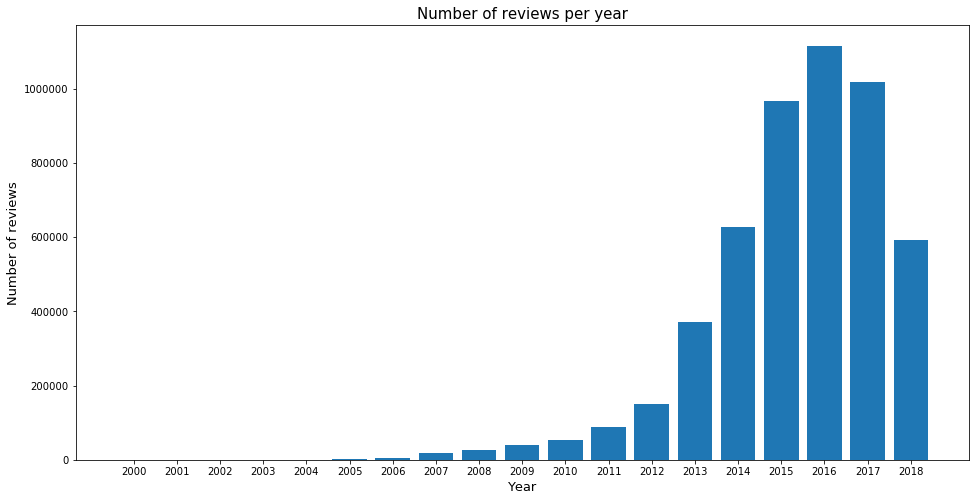

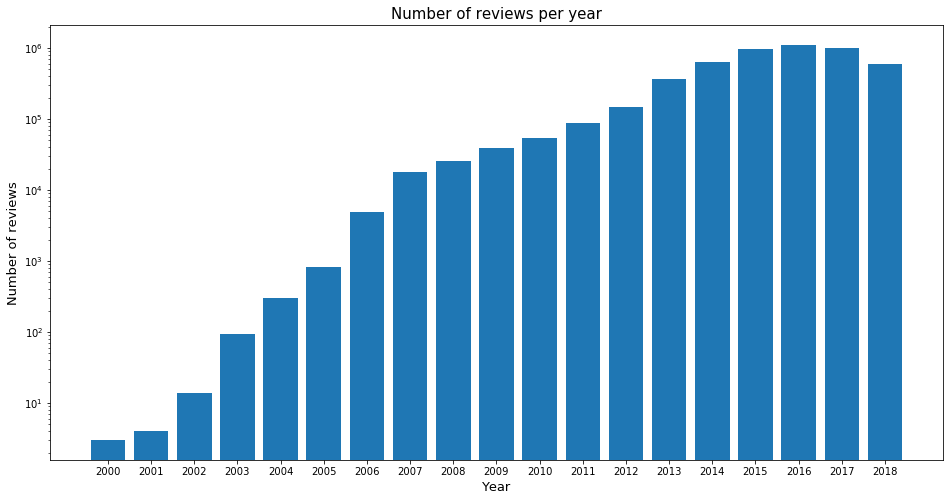

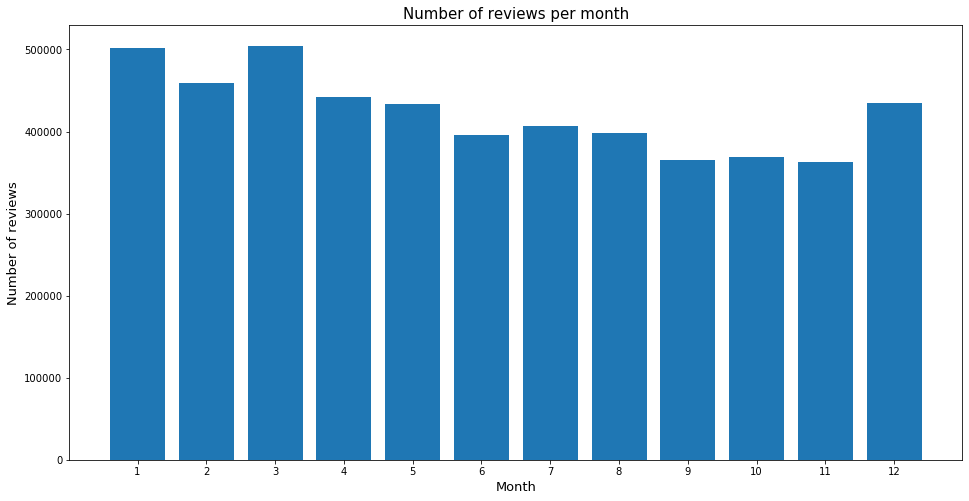

In [35]:
reviews_year = reviews['reviewTime'].map(lambda date: date.year)
args_year = {"data": reviews_year,\
             "title": "Number of reviews per year",\
             "xlabel": "Year",\
             "ylabel": "Number of reviews",\
             "figsize": (16, 8),\
             "categorical": True}

plot_bar_distribution(**args_year)
plot_bar_distribution(**args_year, yscale="log")

reviews_month = reviews['reviewTime'].map(lambda date: date.month)
plot_bar_distribution(reviews_month, title="Number of reviews per month", xlabel="Month", ylabel="Number of reviews", figsize=(16, 8), categorical=True)

As we can see, it indeed increases over the years, except 2018 as we lack reviews.

For the months it's somewhat even, but we can see that Winter is more popular, with Christmas, New Year, Valentine's Day and so on.

## Time series of number of reviews

### BOBER -> THIS KIND OF ASSUME CORRELATION IMPLIES CAUSATION, HENCE BOB THAT AND CITE BAYESIAN STRUCTURAL TIME SERIES TO HAVE CAUSAL INFERENCE

In [24]:
# Create dataframe with number of reviews per product per week, keep only the ones that have a minimum of review
reviews_per_week = pd.DataFrame(reviews[['asin', 'reviewTime']].groupby(['asin', pd.Grouper(key='reviewTime', freq='W')]).size(), columns=['reviewCount'])
reviews_per_week = reviews_per_week.groupby(['asin']).filter(lambda row: row.to_numpy().max() > 7)
reviews_per_week.reset_index(inplace=True)

In [25]:
def plot_time_series(ids, plot_filename):
    """
    Create an interactive plot that show the evolution of the number of reviews for the 
    given products
    
    :param ids: an iterable with the ids (asin) that will be in the plot
    :param plot_filename: the filename of the produced plot
    :return: the path to the plot
    """
    tools = "pan, wheel_zoom"
    p = figure(plot_width=1400, plot_height=800, tools=tools, x_axis_type="datetime")
    num_colors = np.clip(len(ids), 3, 20)
    colors = d3['Category20'][num_colors]
    
    for i, asin in enumerate(ids):
        reviews_asin = reviews_per_week.loc[reviews_per_week['asin'] == asin, ['reviewTime', 'reviewCount']]
        reviews_asin.set_index('reviewTime', inplace=True)
        reviews_asin.sort_index(inplace=True)

        source = ColumnDataSource(reviews_asin)

        p.line('reviewTime', 'reviewCount', source=source, legend_label=str(asin), color=colors[i % 20], line_width=2, alpha=0.8)
    
    p.legend.click_policy="hide"
    
    return write_plot_html(p, plot_filename)

In [64]:
# Plot the time series of a sample (first 10'000 product) of origin dataframe
reviews_per_week_sample = reviews_per_week.loc[reviews_per_week['asin'].isin(reviews.loc[:10000, 'asin']).values, :]
plot_time_series(reviews_per_week_sample['asin'].unique(), 'time_series_first_10000')

/home/lulu/EPFL/MA1/Ada/Project/milestone-2-plots/time_series_first_10000.html

If you go to the above link (you may need to click on "Trust HTML"), you can see that...

In [27]:
id1 = "B0000CFH7B"
id2 = "B0000D916Y"
display(meta["title"][meta["asin"] == id1].values[0])
meta["title"][meta["asin"] == id2].values[0]

'Wilton 710-5506 Color Mist Spray 1.5oz, Black'

"David's Cookies - 24 Fresh Baked M&M Candy Cookie Gourmet Gift Basket - Christmas, Holiday & Corporate Food Tin - Idea For Men & Women - Certified Kosher - 2 lb."

In [28]:
reviews_spray = reviews[["reviewTime", "reviewerID", "reviewText", "summary", "upvote", "stars", 'verified']]\
                        [(reviews["asin"] == id1) &\
                         (reviews["reviewTime"] >= pd.to_datetime("2015-05-22")) &\
                         (reviews["reviewTime"] <= pd.to_datetime("2015-06-15"))]

display(reviews_spray)
date_with_max_reviews = reviews_spray.groupby("reviewTime").agg("size").idxmax()
print(f"Date with max number of reviews: {date_with_max_reviews.date()}")

,reviewTime,reviewerID,reviewText,summary,upvote,stars,verified
4197,2015-06-15,A1Q6MV8HRC58KK,If you go back to the beginning of the reviews there are about 13 pages of nonsense about baking...,Best Shine in the Wasteland,66,5,False
4198,2015-06-13,ABD1G0MCG2QHT,"My cupcakes are all shiny and chrome. I eat, I poop, I eat again.",Five Stars,47,5,False
4199,2015-06-12,A3OX7K7TZ1A6IG,I BUY! I RETURN! I BUY AGAIN!!,Five Stars,123,5,False
4200,2015-06-12,A3N37GJGVFUDJB,Mitch has witnessed me!!!,Five Stars,11,5,False
4201,2015-06-11,ABZC6GUF3EZR9,IT BURNS OH IT BURNS WONDERFULLY\nTHE PATH TO VALHALLA IS NOT A PAINLESS ONE,SHINY AND CHROME,77,5,True
...,...,...,...,...,...,...,...
4363,2015-05-25,A2ANPUFYSVCZCM,Oh what a spray! What a lovely spray!,"So Shiny, So Chrome",3001,5,False
4364,2015-05-23,A3VM93YDITI5DK,Makes it really easy to spot a Warboy who is at the end of their half life and about to become a...,"Brightens up my world, which is fire and blood.",161,5,False
4365,2015-05-23,A1B6CBLRIA9FR1,I LIVE! I DIE! I LIVE AGAIN!,Four Stars,715,4,False
4366,2015-05-23,A29I5F4VUJYXUU,WE WILL RIDE THROUGH THE GATES OF VALHALLA SHINY AND CHROME! WITNESS ME!,Five Stars,1070,5,False


Date with max number of reviews: 2015-05-27


This is quite funny, we managed to find approximately the release date of the famous movie [Mad Max: Fury Road](https://en.wikipedia.org/wiki/Mad_Max:_Fury_Road), which released in 15th May 2015 in USA. But how does a spray relate to this movie, you may wonder, if you haven't seen the movie. In fact the chrome spray became kind of a meme because of popular quotes, otherwise known as the "[Witness me !](https://knowyourmeme.com/memes/witness-me)" meme. In fact most of the reviews quote the movie or change a little bit a quote for comedic effect. Here is a gif of the famous spray inside of the movie:

<img src="https://media.giphy.com/media/vHIz00fcNbseQ/giphy.gif">

The popular quotes include:
> <em>&ldquo;You will ride eternal, shiny and chrome.&rdquo;</em>

> <em>&ldquo;Return my treasures to me, and I myself will carry you through the gates of Valhalla. You shall ride eternal. Shiny, and chrome!&rdquo;</em>

> <em>&ldquo;I live, I die, I live again!&rdquo;</em>

> <em>&ldquo;Witness me.&rdquo;</em>

Of course, the dates that are popular in the reviews are not exactly at the release date but a couple days later and lasted ~3 weeks for this product. The delay can be explained by the fact that the meme wasn't born instantly, people made joke about it, it became popular and ultimately invaded some of the reviews. We can see that most of the reviews have many upvotes. In fact reviews with many upvotes are almost always memes or jokes, so we have to take that into account. If we see many reviews with little upvotes it's probably a product that got popular, but if they have many upvotes it is most likely due to a meme or a group effect.

We can expect other sprays to have similar trends, because the "Witness Me!" meme effect may have affected other sprays on Amazon.

To illustrate that, let's see what does the second product tells us. We begin by showing the reviews of the product during the peak, along with when the trend take place.

In [29]:
reviews_cookie = reviews[["reviewTime", "reviewerID", "reviewText", "summary", "upvote", "stars", "verified"]]\
                        [(reviews["asin"] == id2) &\
                         (reviews["reviewTime"] >= pd.to_datetime("2017-12-08")) &\
                         (reviews["reviewTime"] <= pd.to_datetime("2018-01-22"))]

display(reviews_cookie.head(10))
date_with_max_reviews = reviews_cookie.groupby("reviewTime").agg("size").idxmax()
print(f"Date with max number of reviews: {date_with_max_reviews.date()}")

,reviewTime,reviewerID,reviewText,summary,upvote,stars,verified
7934,2018-01-22,A1VLIWG4U2V54G,"I'm not a huge cookie guy. These were wonderful. Very fresh, very delicious.",These were wonderful. Very fresh,0,5,True
7935,2018-01-22,A129TBMOQD79CZ,Someone sent us a tin of Davids Cookies over the holidays and they were DELICIOUS. These are now...,Not your average tin of cookies!,0,5,False
7936,2018-01-21,A3TYIIZND9LAI4,"These cookies are delicious. They are fresh, soft, flavorful, and the best oatmeal raisin cookie...",Best cookie ever,0,5,True
7937,2018-01-16,AEE3R04IH4T43,"The best cookies ever so chewy, sweet and tasty!",Very good cookies,0,5,True
7938,2018-01-15,AEHEL2XO4RMRF,put in oven before eating,Four Stars,0,4,True
7949,2018-01-15,A2I88LLDJ5UHSA,"Good deal,gift well received",Five Stars,0,5,True
7950,2018-01-15,AX37FB41O04J2,Was sent as a gift. Found a hair baked into a cookie. Good until that point,Good until that,0,2,True
7951,2018-01-15,ARDJ0F5J1V8VV,"They were good and tasty, a very delicious cookie. Fresh baked flavor! The cookie looks and tast...",Tastes and looks full of homemade goodness,0,5,False
7952,2018-01-12,A1OD4XDOWM8S6E,Would be 5 stars if the raisin cookies didn't take over the flavor of every other cookie. They d...,"Theyre good, just get the package without raisins...",0,4,True
7953,2018-01-11,AJO8G0GEMPAAU,"Got them as a Birthday treat for my dad, he said they were delicious!",Four Stars,0,4,False


Date with max number of reviews: 2017-12-15


One way to compare the two product is to see the proportion of people that have actually bought them. If the popularity of one of them comes from the fun in the comments and not from the product itself, we can suppose that the proportion of people that bought the product is quite low. However, in the other situation where the popularity depends on the quality, this proportion should be much higher.

In [249]:
print("Proportion of 'verified' reviews, that is review from people that have confirmed buying the product:")
verif_proportion_spray = reviews_spray['verified'].sum() / reviews_spray['verified'].size
verif_proportion_cookie = reviews_cookie['verified'].sum() / reviews_cookie['verified'].size
print("Spray product: %.1f%%" % (verif_proportion_spray*100))
print("Cookie product: %.1f%%" % (verif_proportion_cookie*100))

Proportion of 'verified' reviews, that is review from people that have confirmed buying the product:
Spray product: 2.3%
Cookie product: 62.7%


We can see how different they are in this measure, this confirm our intuition.

Another thing is that, unlike the first product, all reviews tend to have 0 upvote for the cookie product. This illustrate where its popularity comes from as well: people that buy and put reviews on this product do it because of the quality of the product, not for the fun of it. Also, the peak of interest here is an effect of christmas festivities, the product's goal is to be a gift and it did not happened by chance that the day which got the most interest is just before christmas day.

We search for more product like this, by measuring the difference between its mean, calculated on the number of reviews per week, in days around christmas with the median during all the year. That way, a product that gets more interest in the period of christmas will be picked. This show how we can directly observe the effect of a certain event, here christmas, on the dataset. We calculate it this way so that if the product experience a huge peak at that time, the baseline measure, the median here, is not affected since the median is robust. By taking the difference we have a bias towards product that get more attention in general but this is voluntary, focusing on popular products make the analysis more concrete.

For now, we focus on the two last christmas of the dataset, namely in years 2016 and 2017.

In [71]:
def compute_period_activity(reviews_per_week, start_date, time_delta):
    period_mask = (reviews_per_week['reviewTime'] >= start_date) & (reviews_per_week['reviewTime'] < start_date+time_delta)
    
    year_mask = (reviews_per_week['reviewTime'] >= pd.datetime(start_date.year, 1, 1)) & (reviews_per_week['reviewTime'] < pd.datetime(start_date.year, 12, 31))
    
    product_median_in_year = pd.DataFrame(reviews_per_week.loc[year_mask, :].groupby('asin')['reviewCount'].median())
    product_median_in_year.columns = ['median in year']
    
    period_mean = pd.DataFrame(reviews_per_week.loc[period_mask, :].groupby('asin')['reviewCount'].mean())
    period_mean.columns = ['mean in period']
    
    median_and_mean = product_median_in_year.join(period_mean)
    median_and_mean = median_and_mean.loc[(~median_and_mean['median in year'].isnull()) & (~median_and_mean['mean in period'].isnull()), :]
    median_and_mean['delta'] = median_and_mean['mean in period'] - median_and_mean['median in year']
    median_and_mean.reset_index(inplace=True)
    
    return median_and_mean

In [225]:
median_and_mean_2017 = compute_period_activity(reviews_per_week, pd.datetime(2017, 12, 18), pd.Timedelta('10 days'))
median_and_mean_2017['year'] = 2017
median_and_mean_2016 = compute_period_activity(reviews_per_week, pd.datetime(2016, 12, 18), pd.Timedelta('10 days')) 
median_and_mean_2016['year'] = 2016
median_and_mean = pd.concat([median_and_mean_2016, median_and_mean_2017])
asins_to_plot = median_and_mean.loc[median_and_mean['delta'] > 30, :].merge(meta[['asin', 'title', 'main_cat']], left_on='asin', right_on='asin')
asins_to_plot.drop_duplicates(inplace=True)
print('Products with a peak of interest')
display(asins_to_plot)

plot_time_series(asins_to_plot['asin'].unique(), 'time_series_christmas_peak')

Products with a peak of interest


,asin,median in year,mean in period,delta,year,title,main_cat
0,B0000D9169,3.0,57.5,54.5,2016,"David's Cookies - 24 Fresh Baked Assorted Cookies Gourmet Gift Basket - Christmas, Holiday & Cor...",Grocery
2,B0000D916Y,3.0,57.5,54.5,2016,"David's Cookies - 24 Fresh Baked M&M Candy Cookie Gourmet Gift Basket - Christmas, Holiday & Cor...",Grocery
4,B00KCCKV8W,15.5,293.0,277.5,2016,"Holiday Nuts Gift Basket - Gourmet Food Gifts Prime Delivery - Christmas, Mothers & Fathers Day ...",Grocery
5,B00KCCKV8W,24.5,56.0,31.5,2017,"Holiday Nuts Gift Basket - Gourmet Food Gifts Prime Delivery - Christmas, Mothers & Fathers Day ...",Grocery
6,B00SBT6E8E,2.0,43.0,41.0,2016,CollegeBox - Snacks Care Package (40 Count) for College Students – Variety Assortment Gift Box B...,Grocery
7,B00YPM5X2Y,8.0,55.5,47.5,2016,"Holiday Nuts Gift Basket -Delightful Gourmet Food Gifts Prime Delivery -Christmas Birthday, Than...",Grocery
8,B0131A6FJA,9.0,51.5,42.5,2016,96 Count Variety (10 Amazing Blends) Single-serve Cups for Keurig K-cup Brewers - Premium Roaste...,Grocery
9,B013KTYFYO,7.0,44.5,37.5,2016,Cookies Chips & Candy Snacks Assortment Bulk Sampler by Variety Fun (Care Package 40 Count),Grocery
10,B015G9SH6I,8.0,44.5,36.5,2016,"Five Star Gift Baskets, Holiday Gift Basket - Gourmet Food Nuts and Chocolate, 3 Different Delic...",Grocery
11,B01E9D0OR2,19.0,69.0,50.0,2017,Little Stinker The Original Bag of Unicorn Farts Cotton Candy Funny Novelty Gift for Unique Birt...,Grocery


/home/lulu/EPFL/MA1/Ada/Project/milestone-2-plots/time_series_christmas_peak.html

One thing is for sure; american do love to offer groceries and snacks in this period of the year. Again, the effect that christmas have on products is observable and measurable. This is very good for our direction of analysis, with such an approach we can extract products and analyze further how they are affected and what insights we can extract from their respective reviews. We apply that mindset in the next section, trying to see what words appear more in the christmas context than in general.

# Topic extraction

In [88]:
CHRISTMAS_DATE = pd.datetime(2000, 12, 18)
CHRISTMAS_DURATION = pd.Timedelta('10 days')

In [194]:
def extract_activity_for_event(reviews_week_df, event_start_date, event_duration_days, delta, end_year=2017):
    """extract_activity_for_event takes a dataframe containing the sum of the reviews for a given week and product
    and returns all the products that have a high reviewing activity during the event time"""
    #Create a dataframe containing the most popular product for the given period
    activity = pd.DataFrame()
    for year in range(event_start_date.year, end_year + 1):
        event_start_date = pd.datetime(year, event_start_date.month, event_start_date.day)
        year_activity = compare_period_median_year_mean(reviews_week_df, event_start_date, event_duration_days)
        year_activity = year_activity.loc[year_activity.delta > delta]
        year_activity['event_start_date'] = event_start_date
        activity = pd.concat([activity, year_activity])
    return activity

In [195]:
def extract_reviews_for_event(activity, reviews, event_duration_days, during_event=True):
    """extract_reviews_for_event takes a dataframe containing the products that have a high
    activity during a particular event and return all the reviews corresponding to the latters 
    during the event period or during the rest of the year"""
    reviews = reviews[['reviewTime', 'asin', 'reviewText', 'summary']]
    activity = activity[['asin', 'event_start_date']]
    activity_and_reviews = activity.merge(reviews, on='asin')
    filtered_reviews = pd.DataFrame()
    if during_event:
        filtered_reviews = activity_and_reviews.loc[((activity_and_reviews.event_start_date < activity_and_reviews.reviewTime)\
                                                    & (activity_and_reviews.reviewTime < activity_and_reviews.event_start_date + event_duration_days))]
    else:
        filtered_reviews = activity_and_reviews.loc[(~(activity_and_reviews.event_start_date < activity_and_reviews.reviewTime)\
                                                    & (activity_and_reviews.reviewTime < activity_and_reviews.event_start_date + event_duration_days))]
    return filtered_reviews[['asin', 'reviewTime', 'reviewText', 'summary']].copy()

In [196]:
def lemmatize_and_count(event_reviews):
    """lemmatize_and_count takes a dataframe containing reviews and summaries
    and lemmatizes the latters. It returns a dataframe with the number of times
    a given word appears sorted descendingly"""
    event_texts = pd.DataFrame(event_reviews['reviewText'] + ' ' + event_reviews['summary'], columns=['text'])
    lemmatized_event_texts = pd.DataFrame(event_texts['text'].apply(lemmatize))
    lemmatized_event_words_count = pd.DataFrame(lemmatized_event_texts.explode('text').groupby('text').size(), columns=['count'])
    return lemmatized_event_words_count.sort_values(by='count', ascending=False)

In [326]:
def compute_freq(word_count_1, word_count_2):
    """normalize_word_count com"""
    nb_word_1 = word_count_1['count'].values.sum()
    word_count_1['count'] = word_count_1['count'] / nb_word_1
    nb_word_2 = word_count_2['count'].values.sum()
    word_count_2['count'] = word_count_2['count'] / nb_word_2
    return word_count_1, word_count_2

In [327]:
def compute_and_compare_freq(event_word_count, non_event_word_count, min_freq=0.0005, ratio=True, columns=['event', 'not_event']):
    event_word_count_n, non_event_word_count_n = compute_freq(event_word_count, non_event_word_count)
    word_frequencies = event_word_count_n.merge(non_event_word_count_n, how='left', on='text')
    word_frequencies.columns = columns
    if ratio:
        word_frequencies = word_frequencies.fillna(0.0000001)
        word_frequencies['ratio'] = word_frequencies[columns[0]] / word_frequencies[columns[1]]
    else:
        word_frequencies = word_frequencies.fillna(0)
        word_frequencies['difference'] = word_frequencies[columns[0]] - word_frequencies[columns[1]]
    word_frequencies = word_frequencies.loc[word_frequencies[columns[0]] > min_freq]
    return word_frequencies.sort_values(by=word_frequencies.columns[-1], ascending=False)

## Chirstmas

In [299]:
christmas_activity = extract_activity_for_event(reviews_per_week, CHRISTMAS_DATE, CHRISTMAS_DURATION, 10)
christmas_reviews = extract_reviews_for_event(christmas_activity, reviews, CHRISTMAS_DURATION)
christmas_word_count = lemmatize_and_count(christmas_reviews)

In [197]:
non_christmas_reviews = extract_reviews_for_event(christmas_activity, reviews, CHRISTMAS_DURATION, during_event=False)
non_christmas_word_count = lemmatize_and_count(non_christmas_reviews)

In [328]:
columns_christmas = ['christmas', 'not_in_christmas']
freq_and_difference = compute_and_compare_freq(christmas_word_count, non_christmas_word_count, ratio=False, columns=columns_christmas)
freq_and_ratio = compute_and_compare_freq(christmas_word_count, non_christmas_word_count, columns=columns_christmas)

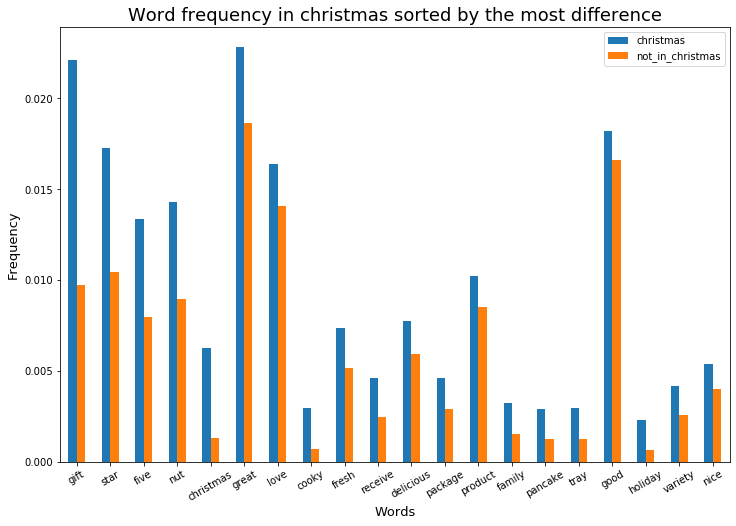

In [329]:
ax = freq_and_difference[columns_christmas].head(20).plot.bar(rot=30, figsize=(12,8))
ax.set_xlabel('Words', fontsize=13)
ax.set_ylabel('Frequency', fontsize=13)
_ = ax.set_title(f'Word frequency in {columns_christmas[0]} sorted by the most difference', fontsize=18)

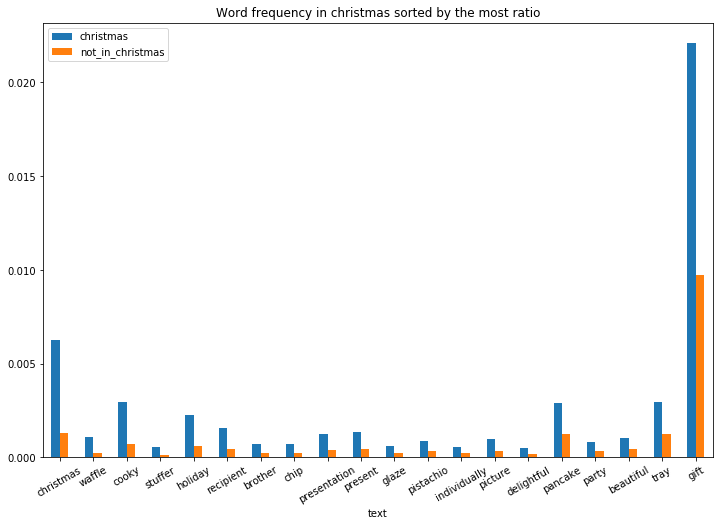

In [330]:
_ = freq_and_ratio[columns_christmas].head(20).plot.bar(rot=30, figsize=(12,8), title=f'Word frequency in {columns_christmas[0]} sorted by the most ratio')

## Word2Vec for veganism

In [ ]:
from gensim.models import Word2Vec, KeyedVectors

# reference of model: https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit?usp=sharing
# Taken from https://mccormickml.com/2016/04/12/googles-pretrained-word2vec-model-in-python/
google_model = KeyedVectors.load_word2vec_format('./data/GoogleNews-vectors-negative300.bin', binary=True)

In [ ]:
christmas_words = ['present', 'gift', 'snow', 'turkey', 'gingerbread', 'christmas', 'Christmas', 'family', 'dinner', 'stuff', 'stuffing', 'cranberry', 'cranberries', 'champagne', 'candy', 'cane', 'pie']
veg_words = ['vegan', 'vegetarian', 'organic', 'raw', 'health', 'green', 'bean', 'soy', 'tofu', 'tempeh', 'granola', 'hummus', 'Vegan', 'gluten_free', 'vegans', 'vegetarians', 'vegeterian', 'nonmeat', 'avocado']

In [ ]:
def compare_review(model, review_texts, word_set):
    for review_text in review_texts:
        valid_text = [word for word in review_text if word in model.vocab]
        if len(valid_text) == 0:
            continue
        sim = model.n_similarity(valid_text, word_set)
        if sim > 0.4:
            print(sim, ":\n", valid_text)

In [ ]:
google_model.most_similar(['christmas', 'food', 'meal', 'turkey', 'gravy', 'stuffing'])

In [ ]:
google_model.most_similar(positive=['vegan', 'food'], negative=['meat'])

## Lemmatization of the reviewText for analysis

In [86]:
import string
import nltk
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

lemmatizer = WordNetLemmatizer()
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger');

def remove_punctuation(s):
    punct_chars = string.punctuation
    translator_punct = s.maketrans(punct_chars, ' ' * len(punct_chars))
    
    return s.translate(translator_punct)

def remove_stopwords(s):
    stopwords_np = np.array(stopwords.words('english'))
    words = np.array(s.split())
    words_filtered = words[~np.in1d(words, stopwords_np)]
    
    return ' '.join(words_filtered)

def transform_tag(tag):
    tag_prefix = tag[0].lower()
    if tag_prefix in ['n', 'r', 'v', 'j']:
        return 'a' if tag_prefix == 'j' else tag_prefix
    else:
        return 'n'

def lemmatize(t):
    t = remove_punctuation(t)
    t = remove_stopwords(t)
    t_token = word_tokenize(t)
    t_tags = pos_tag(t_token)
    print(t_tags)
    t_lemm = [lemmatizer.lemmatize(w, transform_tag(t)) for w, t in t_tags]
    return ' '.join(t_lemm)

[nltk_data] Error loading punkt: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>
[nltk_data] Error loading wordnet: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>
[nltk_data] Error loading averaged_perceptron_tagger: <urlopen error
[nltk_data]     [Errno -3] Temporary failure in name resolution>


In [87]:
print('Example of lemmatizing pipeline')
testpd = pd.DataFrame(np.array([['I tried to stop some words to see  the lemmatizing. \nWords word!! alias-alias to and'], 
                                ['Here we\'ll see.']]), columns=['raw'])
testpd['lemmatized'] = testpd['raw'].apply(lemmatize)
testpd

Example of lemmatizing pipeline
[('I', 'PRP'), ('tried', 'VBD'), ('stop', 'JJ'), ('words', 'NNS'), ('see', 'VBP'), ('lemmatizing', 'JJ'), ('Words', 'NNP'), ('word', 'NN'), ('alias', 'NN'), ('alias', 'NN')]
[('Here', 'RB'), ('see', 'VB')]


,raw,lemmatized
0,I tried to stop some words to see the lemmati...,I try stop word see lemmatizing Words word ali...
1,Here we'll see.,Here see


In [ ]:
# Very slow, didn't run yet
reviews["reviewTextLemma"] = reviews['reviewText'].apply(lemmatize)
reviews